In [16]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
#export
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import pandas as pd
from sklearn.model_selection import train_test_split

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from exp.nb_config import *

In [18]:
#export
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_type_vi_dict = {
    'nv': 'Nốt ruồi',
    'mel': 'Ung thư hắc tố',
    'bkl': 'U sừng hóa ác tính ',
    'bcc': 'U da ung thư tế bào đáy',
    'akiec': 'Dày sừng quang hóa',
    'vasc': 'Thương tổn mạch máu',
    'df': 'U da lành tính'
}

In [19]:
PathConfig.CSV_PATH

'..\\data\\HAM10000_metadata.csv'

In [20]:
#export
def preprocess_df(df, valid_size=0.2, seed=AppConfig.SEED):

    df['path'] = PathConfig.IMAGE_PATH + '/' + df['image_id'] + '.jpg'
    df['label_fullstr'] = df['dx'].map(lesion_type_dict.get)

    label_str = pd.Categorical(df['label_fullstr'])
    df['label_index'] = label_str.codes

    df_undup = df.groupby('lesion_id').count()
    df_undup = df_undup[df_undup['image_id'] == 1]
    df_undup.reset_index(inplace=True)

    _, valid = train_test_split(df_undup['lesion_id'], test_size=valid_size, 
                                random_state=seed, 
                                stratify=df_undup['label_index'])
    valid = set(valid)
    df['val'] = df['lesion_id'].apply(lambda x: 1 if str(x) in valid else 0)

    df_train = df[df['val'] == 0]
    df_valid = df[df['val'] == 1]

    return df_train.reset_index(drop=True), df_valid.reset_index(drop=True), list(label_str.categories)

In [21]:
df = pd.read_csv(PathConfig.CSV_PATH)
train_df, valid_df, labels = preprocess_df(df)

In [22]:
train_df.shape, valid_df.shape

((8912, 11), (1103, 11))

In [23]:
train_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,label_fullstr,label_index,val
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,..\data\images/ISIC_0027419.jpg,Benign keratosis-like lesions,2,0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,..\data\images/ISIC_0025030.jpg,Benign keratosis-like lesions,2,0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,..\data\images/ISIC_0026769.jpg,Benign keratosis-like lesions,2,0
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,..\data\images/ISIC_0025661.jpg,Benign keratosis-like lesions,2,0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,..\data\images/ISIC_0031633.jpg,Benign keratosis-like lesions,2,0
...,...,...,...,...,...,...,...,...,...,...,...
8907,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,..\data\images/ISIC_0033084.jpg,Actinic keratoses,0,0
8908,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,..\data\images/ISIC_0033550.jpg,Actinic keratoses,0,0
8909,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,..\data\images/ISIC_0033536.jpg,Actinic keratoses,0,0
8910,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,..\data\images/ISIC_0032854.jpg,Actinic keratoses,0,0


In [24]:
#export
class SkinDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __getitem__(self, i):
        x = Image.open(self.df['path'][i])
        y = torch.tensor(int(self.df['label_index'][i]))

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.df)

In [25]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [26]:
train_ds = SkinDataset(train_df, transform)
valid_ds = SkinDataset(valid_df, transform)

In [27]:
train_dl = DataLoader(train_ds, batch_size=TrainConfig.BATCH_SIZE)
valid_dl = DataLoader(valid_ds, batch_size=TrainConfig.BATCH_SIZE)

tensor(2)

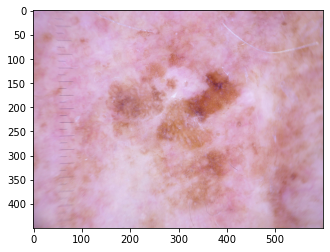

In [41]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].permute(1, 2, 0))
yb[0]

In [29]:
#export
class SkinDataBunch:
    def __init__(self, train_dl, valid_dl, labels):
        self.train_dl,self.valid_dl,self.labels, self.c = train_dl,valid_dl,labels,len(labels)

    @property
    def train_ds(self): return self.train_dl.dataset

    @property
    def valid_ds(self): return self.valid_dl.dataset

    def show_image(self, index=None):
        dataset = self.train_ds
        n_samples = len(dataset)

        if not index:
            index = int(np.random.random()*n_samples)
        else:
            if index >= n_samples or index < 0:
                print('Invalid index.')
                return

        x, y = dataset[index]

        plt.imshow(x.permute(1,2,0))
        plt.axis('off')
        plt.title(self.labels[y])

    def show_grid(self, n_rows=5, n_cols=5):
        dataset = self.train_ds
        array = torch.utils.data.Subset(dataset, np.random.choice(len(dataset), n_rows*n_cols, replace=False))

        plt.figure(figsize=(12, 12))
        for row in range(n_rows):
            for col in range(n_cols):
                index = n_cols * row + col
                plt.subplot(n_rows, n_cols, index + 1)
                plt.imshow(array[index][0].permute(1, 2, 0))
                plt.axis('off')
                label = self.labels[int(array[index][1])]
                plt.title(label, fontsize=12)
        plt.tight_layout()


In [30]:
db = SkinDataBunch(train_dl, valid_dl, labels)

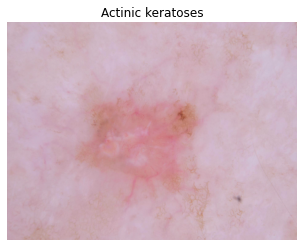

In [33]:
db.show_image()

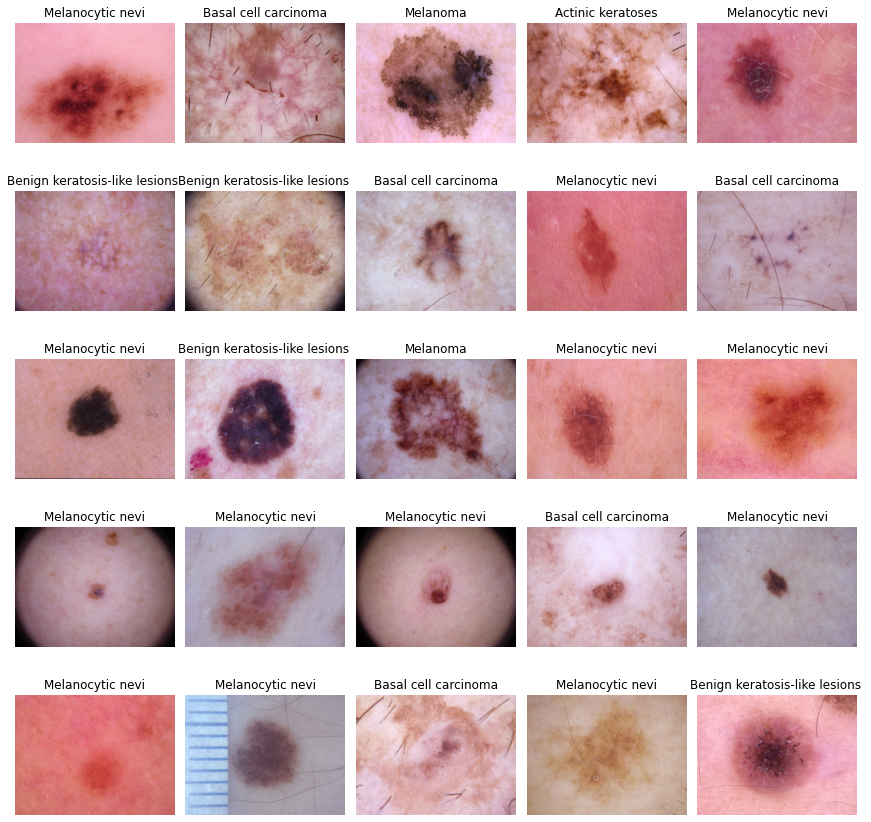

In [34]:
db.show_grid()

In [42]:
#export
def get_skin_databunch(size=100, transform=None):
    df = pd.read_csv(PathConfig.CSV_PATH)
    train_df, valid_df, labels = preprocess_df(df)
    if not transform:
        transform = transforms.Compose([
            transforms.ToTensor()
        ])
    train_ds = SkinDataset(train_df[:size], transform)
    valid_ds = SkinDataset(valid_df[:size], transform)
    train_dl = DataLoader(train_ds, batch_size=TrainConfig.BATCH_SIZE)
    valid_dl = DataLoader(valid_ds, batch_size=TrainConfig.BATCH_SIZE)
    db = SkinDataBunch(train_dl, valid_dl, labels)
    return db

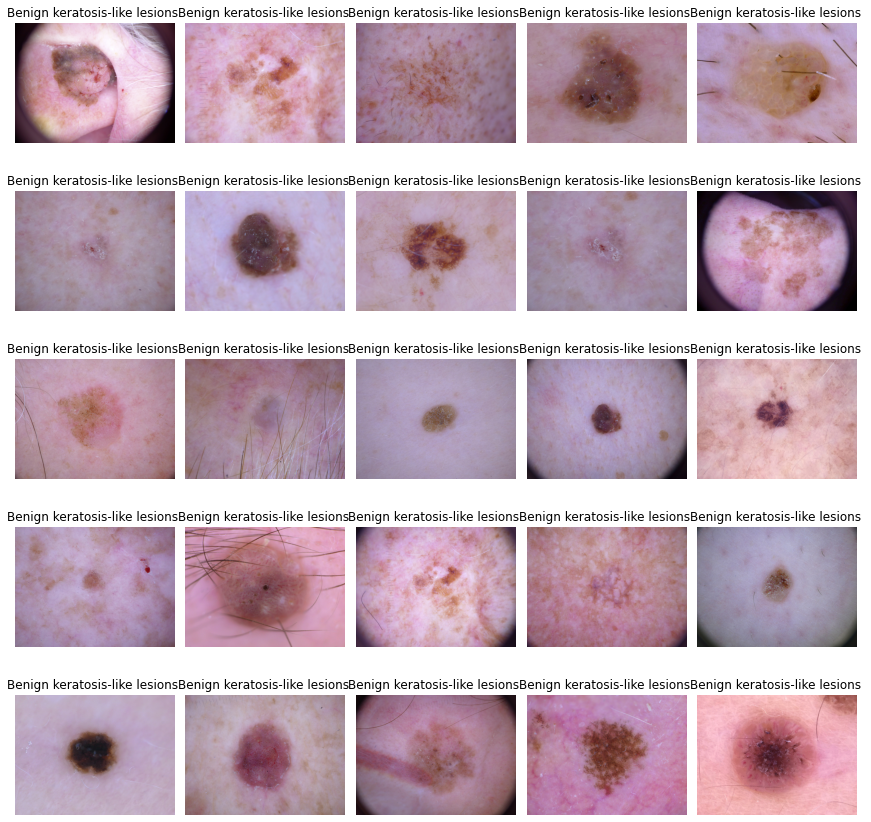

In [37]:
db = get_skin_databunch()
db.show_grid()

In [43]:
!python notebook2script.py dataset.ipynb

Converted dataset.ipynb to exp\nb_dataset.py
